# Interpretabble image classifier using deep learning

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import torch.utils.data
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import numpy as np

# Plan

1. Define basic skeleton
2. Train and test that feature model works
    2.1 Define dataset loaders
    2.2 Plot some training and test images from data loaders
    2.3 Write fit function
    2.4 Write evaluate function
3. Train and test adhoc model
4. Visualize heatmap

In [64]:
class FeatureModel(nn.Module):
    def __init__(self):
        '''
        Define model that maps (3, Q, Q) to (V)        
        '''
        super(FeatureModel, self).__init__()
        self.l1 = self.get_conv_layer((1, 64, 3))
        self.l2 = self.get_conv_layer((64, 64, 3))
        self.l3 = self.get_conv_layer((64, 128, 3))
        self.l = nn.Sequential(*[self.l1, self.l2, self.l3])
        self.fc1 = nn.Linear(128*22*22, 100)

    def get_conv_layer(self, param):
        return nn.Sequential(*[nn.Conv2d(*param), nn.BatchNorm2d(param[1]), nn.ReLU()])
        
    def forward(self, x):
        '''
        Args
            patch - (3, Q, Q)
        Returns
            representation - (V)
        Convolutional neural network that maps patch to a vector
        '''
        x1 = self.l(x)
        return self.fc1(x1.view(-1, 128*22*22))

model = FeatureModel()
model(torch.randn(1, 1, 28, 28)).shape


torch.Size([1, 100])

In [66]:
class AdhocNet(nn.Module):
    def __init__(self, patch_size):
        super(AdhocNet, self).__init__()
        self.patch_size = patch_size
        self.feature_model = FeatureModel()
        self.predictor = nn.Linear(100, 10)
            
    def img_to_patch(self, img, patch_size):
        '''
        Args
            img - (3, W, H)
            patch_size - (Q)
        Returns
            Patches (W/Q, H/Q, 3, Q, Q)
        '''
        num_patches = int(img.shape[1] / patch_size)
        img1 = torch.stack(torch.split(img, num_patches, dim=2))
        img2 = torch.stack(torch.split(img1, num_patches, dim=2))
        return img2.permute(3, 4, 2, 0, 1)
    
   
    def patches_to_representations(self, patches):
        '''
        Args
            patches - (W/Q, H/Q, 3, Q, Q)
        Returns
            representations - (W/Q, H/Q, V)
        '''
        representations = []
        for i in range(patches.shape[0]):
            row = []
            for j in range(patches.shape[1]):
                features = self.feature_model(patches[i,j].unsqueeze(0))
                row.append(features[0])
            representations.append(torch.stack(row))
        representations = torch.stack(representations)
        return representations

    def forward(self, x):
        batch_patches = torch.stack([self.img_to_patch(img, self.patch_size) for img in x])
        batch_representations = torch.stack([ self.patches_to_representations(patches) for patches in batch_patches])
        return batch_representations
        

model = AdhocNet(10)
#rep = model(torch.randn(1, 3, 200, 200))
#rep.shape

## Data

In [67]:
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
])
train_loader = torch.utils.data.DataLoader(datasets.FashionMNIST('../data', train=True, download=True, transform = transform),
        batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.FashionMNIST('../data', train=False, download=True, transform = transform),
        batch_size=1, shuffle=True)
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7f40fe174748>,
 <torch.utils.data.dataloader.DataLoader at 0x7f40fdbfdef0>)

## Plot some images from train and test


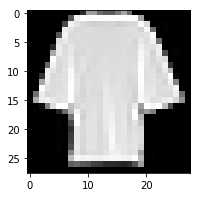

Pullover


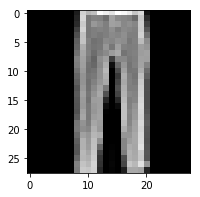

Trouser


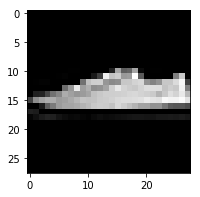

Sneaker


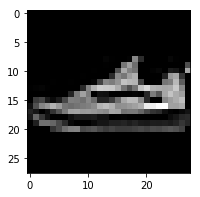

Sneaker


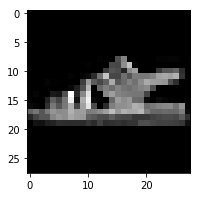

Sandal


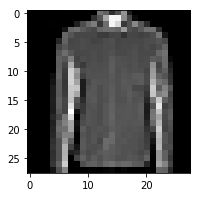

Shirt


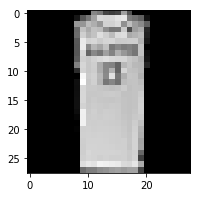

T-shirt/top


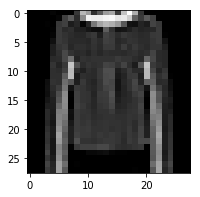

Shirt


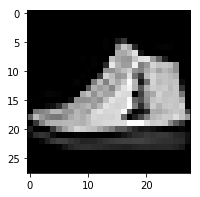

Sneaker


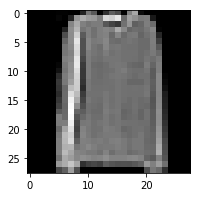

Shirt


In [68]:
label_map = { 0: 'T-shirt/top', 1:'Trouser', 2 : 'Pullover',
              3: 'Dress', 4 : 'Coat', 5 : 'Sandal',
              6 : 'Shirt', 7 : 'Sneaker', 8: 'Bag',
              9 : 'Ankle boot'}

def visualize_dataset(data_loader):
    for _ in range(5):
        inputs, outputs = next(iter(data_loader))
        plt.figure(figsize=(3,3))
        plt.imshow(inputs[0][0], cmap = 'gray')
        plt.show()
        print(label_map[outputs[0].item()])
    
visualize_dataset(train_loader)
visualize_dataset(test_loader)
    

## Define fit function


In [70]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.base_model = FeatureModel()
        self.fc1 = nn.Linear(100, 10)
    def forward(self, x):
        x1 = self.base_model(x)
        return self.fc1(x1)
    
classifier = Classifier()
classifier(torch.randn(1, 1, 28, 28)).shape

torch.Size([1, 10])

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

def fit(model, train_loader, metric, optimizer, epochs = 5, log_every = 100):
    for j in range(epochs):
        total = 0
        correct = 0
        losses = []
        for i, (inputs, outputs) in enumerate(train_loader):
            optimizer.zero_grad()
            predictions = model(inputs)
            loss = metric(predictions, outputs)  
            correct += sum(torch.max(predictions, -1)[1] == outputs).item()
            total += predictions.shape[0]
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            if i%log_every == 0:
                print(i, j, np.mean(losses), correct/total)
                
fit(classifier, train_loader, criterion, optimizer, epochs = 3, log_every = 100)

## Define evaluate function


In [77]:
def evaluate(model, test_loader):
    correct = 0
    total = 0
    for i, data in enumerate(test_loader):
        inputs, outputs = data
        predictions = model(inputs)
        predictions = torch.max(predictions, -1)[1]
        correct += sum(predictions == outputs).item()
        total += predictions.shape[0]
        if i%1000 == 0:
            print(i)
    return correct / total
        
        
evaluate(classifier, test_loader)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


0.8093

## Visualize representations